In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python langchain_nvidia_ai_endpoints

In [2]:
!pip install -U -q "google-genai>=1.16.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.6/222.6 kB 5.3 MB/s eta 0:00:00


In [3]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [ ]:
# from typing_extensions import TypedDict
# from typing import  Annotated, List, Optional, Literal
# from pydantic import BaseModel, Field
# from pydantic.fields import FieldInfo
# import operator
# class OutputState(TypedDict):
#   genre:str
#   synopsis:str
#   theme: str
#   title: str
#   protoganist: str
#   tone: str

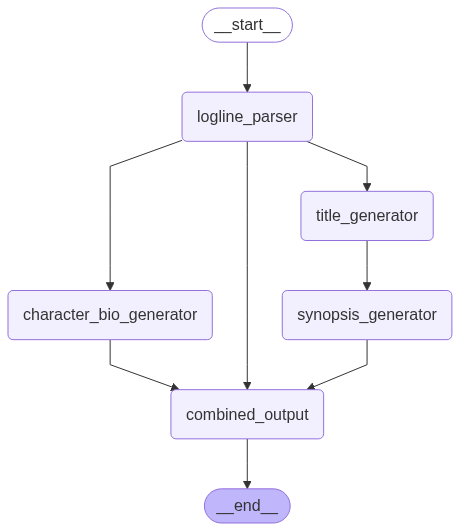

{'logline': 'A young wizard must find a magical artifact to save his world from an evil sorcerer.', 'logline_response': '```json\n{\n  "genre": "Fantasy",\n  "themes": [\n    "Good vs. Evil",\n    "Heroism",\n    "Quest",\n    "Saving the World"\n  ],\n  "protagonist": {\n    "type": "Young Wizard",\n    "goal": "Find a magical artifact"\n  },\n  "conflict": {\n    "antagonist": "Evil Sorcerer",\n    "stakes": "Saving his world",\n    "challenge": "Locating a magical artifact"\n  },\n  "tone": "Heroic, Adventurous"\n}\n```', 'title_response': 'The Last Rune', 'synopsis_response': "The world of Eldoria teeters on the brink of eternal shadow, threatened by the insidious reign of the malevolent Sorcerer, Xylo. Only young Elara, an untested but determined wizard with a burgeoning gift for magic, stands as a beacon of hope. A prophecy speaks of The Last Rune, an ancient artifact rumored to hold the key to repelling Xylo's darkness and restoring balance to Eldoria. Tasked with a destiny far 

In [27]:
from langchain.prompts import PromptTemplate
from google import genai
from google.genai import types
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field
from pydantic.fields import FieldInfo
import operator

class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])])
  return {"logline_response": logline_response.text}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)])
  return {"title_response": title_response.text}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)])
  return {"synopsis_response": synopsis_response.text}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)])
  return {"character_bio_response": character_bio_response.text}

def combined_output(state: GraphState):
  return state

g = StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("combined_output",combined_output)
g.add_edge(START, "logline_parser")
g.add_edge("logline_parser", "title_generator")
g.add_edge("logline_parser", "character_bio_generator")
g.add_edge("title_generator", "synopsis_generator")
g.add_edge("synopsis_generator", "combined_output")
g.add_edge("character_bio_generator", "combined_output")
g.add_edge("logline_parser", "combined_output")
g.add_edge("combined_output", END)


graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

# Sample logline and initial state
sample_logline = "A young wizard must find a magical artifact to save his world from an evil sorcerer."
initial_state = {"logline": sample_logline}

# Invoke the graph
output = graph.invoke(initial_state)
print(output)

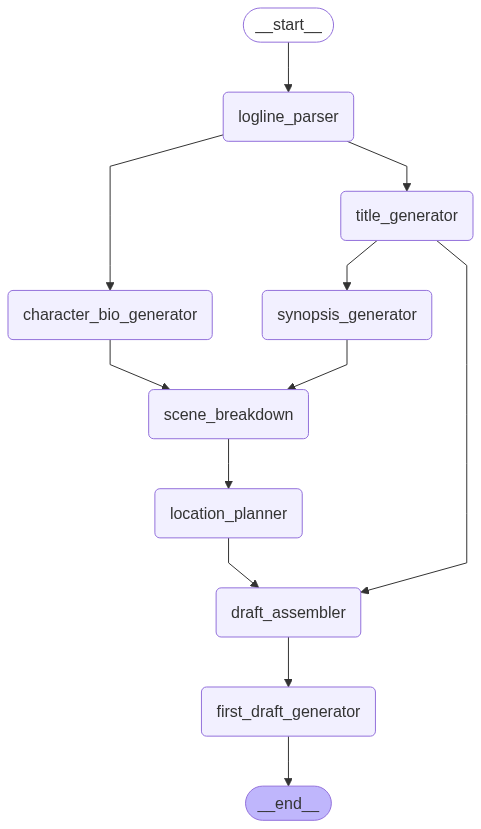

In [47]:
from langchain.prompts import PromptTemplate
from google import genai
from google.genai import types
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from typing import  Annotated, List, Optional, Literal
from pydantic import BaseModel, Field
from pydantic.fields import FieldInfo
import operator

class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str
  scenebreakdown: str
  locations: str
  draft_skeleton: str
  first_draft: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])]).text
  return {"logline_response": logline_response}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)]).text
  return {"title_response": title_response}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)]).text
  return {"synopsis_response": synopsis_response}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)]).text
  return {"character_bio_response": character_bio_response}

scenebreakdown_template = PromptTemplate(
  input_variables=["title", "synopsis", "character_bios"],
  template=(
    "Role: You are a story architect.\n"
    "Task: Break down the story with Title: {title}, Synopsis: {synopsis}, Characters: {character_bios} into 8–12 key scenes.\n"
    "Format Constraints: Return a JSON array of objects with keys: scene_no, goal, stakes, summary.\n"
    "Output Style: Strategic, storyflow-oriented, prioritized."
  )
)
locations_template = PromptTemplate(
  input_variables=["scenebreakdown"],
  template=(
    "Role: You are a cinematic setting designer.\n"
    "Task: For each scene in the breakdown below, suggest 1–2 evocative locations/settings.\n"
    "Scene Breakdown JSON: {scenebreakdown}\n"
    "Format Constraints: Return a JSON array of objects with keys: scene_no, location_description.\n"
    "Output Style: Vivid, visual, mood-enhancing."
  )
)

draft_assembler_template = PromptTemplate(
    input_variables=["title", "synopsis", "characters", "scenes", "locations"],
    template=(
        "Role: You are a script organizer.\n"
        "Task: Combine the provided story components into a structured draft skeleton to guide scriptwriting.\n\n"
        "Title: {title}\n"
        "Synopsis: {synopsis}\n"
        "Characters JSON: {characters}\n"
        "Scenes JSON: {scenes}\n"
        "Locations JSON: {locations}\n\n"
        "Format: Return a single JSON object with keys:\n"
        " - title\n - synopsis\n - characters (as array)\n - scenes (array of objects with: scene_no, summary, location)\n"
        "Output Style: Clean, structured, and parseable."
    )
)

first_draft_template = PromptTemplate(
    input_variables=["draft_skeleton"],
    template=(
        "Role: You are a professional scriptwriter.\n"
        "Task: For each scene in the story skeleton below, write detailed action lines and dialogue.\n\n"
        "Draft Skeleton JSON: {draft_skeleton}\n\n"
        "Format: Return a JSON array where each element includes:\n"
        "- scene_no\n- action_lines\n- dialogue_script\n\n"
        "Output Style: Cinematic, emotionally engaging, consistent with character bios and tone."
    )
)

def scene_breakdown(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[scenebreakdown_template.format(
            title=state["title_response"],
            synopsis=state["synopsis_response"],
            character_bios=state["character_bio_response"]
        )]
    ).text
    return {"scenebreakdown": resp}

def location_planner(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[locations_template.format(
            scenebreakdown=state["scenebreakdown"]
        )]
    ).text
    return {"locations": resp}

def draft_assembler(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[
            draft_assembler_template.format(
                title=state["title_response"],
                synopsis=state["synopsis_response"],
                characters=state["character_bio_response"],
                scenes=state["scenebreakdown"],
                locations=state["locations"]
            )
        ]
    ).text
    return {"draft_skeleton": resp}

def first_draft_generator(state: GraphState):
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[first_draft_template.format(
            draft_skeleton=state["draft_skeleton"]
        )]
    ).text
    return {"first_draft": resp}


g=StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("scene_breakdown",scene_breakdown)
g.add_node("location_planner",location_planner)
g.add_node("draft_assembler",draft_assembler)
g.add_node("first_draft_generator", first_draft_generator)


g.add_edge(START,"logline_parser")
g.add_edge("logline_parser","title_generator")
g.add_edge("logline_parser","character_bio_generator")
g.add_edge("title_generator","synopsis_generator")

g.add_edge("synopsis_generator","scene_breakdown")
g.add_edge("character_bio_generator","scene_breakdown")

g.add_edge("scene_breakdown","location_planner")

# Modified edges leading to draft_assembler
g.add_edge("location_planner","draft_assembler")
g.add_edge("title_generator","draft_assembler") # Add edge from title_generator to draft_assembler


g.add_edge("draft_assembler","first_draft_generator")
g.add_edge("first_draft_generator", END)


graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [48]:
result = graph.invoke({"logline": "A young wizard must find a magical artifact to save his world from an evil sorcerer."})
print(result["first_draft"])

KeyError: 'synopsis_response'

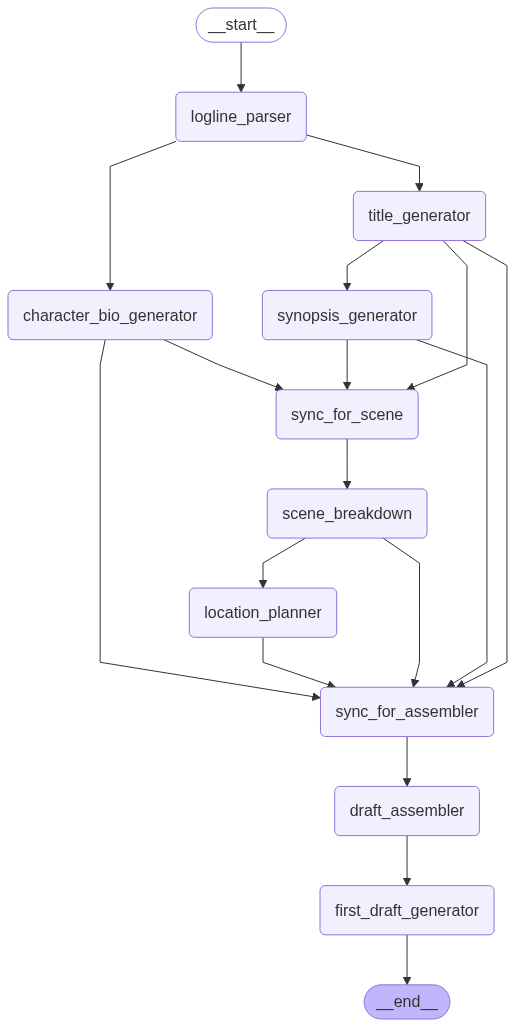

RuntimeError: sync_for_assembler: missing keys ['scenebreakdown', 'locations', 'synopsis_response']

In [58]:
import json
class GraphState(TypedDict):
  logline: str
  logline_response: str
  title_response: str
  synopsis_response: str
  character_bio_response: str
  scenebreakdown: str
  locations: str
  draft_skeleton: str
  first_draft: str

logline_parser_template = PromptTemplate(
  input_variables=["logline"],
  template=(
    "Role: You are a professional script development assistant.\n"
    "Task: Parse the following logline into its core elements.\n"
    "Logline: {logline}\n"
    "Format Constraints: Respond ONLY in JSON format with keys: genre, themes, protagonist, conflict, tone.\n"
    "Output Style: Clean, concise, and actionable."
  )
)

title_generator_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a script marketer.\n"
        "Task: Generate a compelling and memorable title for the script based on the parsed logline below.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a single title string.\n"
        "Output Style: Concise, attention-grabbing, genre-appropriate."
    )
)

synopsis_generator_template = PromptTemplate(
    input_variables=["parsed_logline", "title"],
    template=(
        "Role: You are an experienced screenwriter.\n"
        "Task: Write a 2–3 paragraph synopsis that captures beginning, middle, and end based on the parsed logline and title.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Title: {title}\n"
        "Format Constraints: Output as plain text with paragraphs.\n"
        "Output Style: Insightful, emotionally engaging, concise."
    )
)

character_bio_template = PromptTemplate(
    input_variables=["parsed_logline"],
    template=(
        "Role: You are a character development specialist.\n"
        "Task: Generate detailed bios for the major characters implied by the logline.\n"
        "Parsed Logline: {parsed_logline}\n"
        "Format Constraints: Return a JSON array. Each entry must include: name, role, motivation, character arc, quirks.\n"
        "Output Style: Structured, clear, character-driven."
    )
)

def logline_parser(state: GraphState):
  logline_response = client.models.generate_content(model="gemini-2.5-flash",contents=[logline_parser_template.format(logline=state["logline"])])
  return {"logline_response": logline_response.text}

def title_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title_response = client.models.generate_content(model="gemini-2.5-flash",contents=[title_generator_template.format(parsed_logline=parsed_logline)])
  return {"title_response": title_response.text}

def synopsis_generator(state: GraphState):
  parsed_logline = state['logline_response']
  title = state['title_response']
  synopsis_response = client.models.generate_content(model="gemini-2.5-flash",contents=[synopsis_generator_template.format(parsed_logline=parsed_logline, title=title)])
  return {"synopsis_response": synopsis_response.text}

def character_bio_generator(state: GraphState):
  parsed_logline = state['logline_response']
  character_bio_response = client.models.generate_content(model="gemini-2.5-flash",contents=[character_bio_template.format(parsed_logline=parsed_logline)])
  return {"character_bio_response": character_bio_response.text}

scenebreakdown_template = PromptTemplate(
    input_variables=["title", "synopsis", "character_bios"],
    template=(
        "Role: You are a story architect.\n"
        "Task: Break down the story with Title: {title}, Synopsis: {synopsis}, Characters: {character_bios} into 8–12 key scenes.\n"
        "Format Constraints: Return a JSON array of objects with keys: scene_no, goal, stakes, summary.\n"
        "Output Style: Strategic, storyflow-oriented, prioritized."
    )
)

locations_template = PromptTemplate(
    input_variables=["scenebreakdown"],
    template=(
        "Role: You are a cinematic setting designer.\n"
        "Task: For each scene in the breakdown below, suggest 1–2 evocative locations/settings.\n"
        "Scene Breakdown JSON: {scenebreakdown}\n"
        "Format Constraints: Return a JSON array of objects with keys: scene_no, location_description.\n"
        "Output Style: Vivid, visual, mood-enhancing."
    )
)

draft_assembler_template = PromptTemplate(
    input_variables=["title", "synopsis", "characters", "scenes", "locations"],
    template=(
        "Role: You are a script organizer.\n"
        "Task: Combine the provided story components into a structured draft skeleton to guide scriptwriting.\n\n"
        "Title: {title}\n"
        "Synopsis: {synopsis}\n"
        "Characters JSON: {characters}\n"
        "Scenes JSON: {scenes}\n"
        "Locations JSON: {locations}\n\n"
        "Format: Return a single JSON object with keys:\n"
        " - title\n - synopsis\n - characters (as array)\n - scenes (array of objects with: scene_no, summary, location)\n"
        "Output Style: Clean, structured, and parseable."
    )
)

first_draft_template = PromptTemplate(
    input_variables=["draft_skeleton"],
    template=(
        "Role: You are a professional scriptwriter.\n"
        "Task: For each scene in the story skeleton below, write detailed action lines and dialogue.\n\n"
        "Draft Skeleton JSON: {draft_skeleton}\n\n"
        "Format: Return a JSON array where each element includes:\n"
        "- scene_no\n- action_lines\n- dialogue_script\n\n"
        "Output Style: Cinematic, emotionally engaging, consistent with character bios and tone."
    )
)

def scene_breakdown(state: GraphState):
    print("[node] scene_breakdown started")
    # Validate required inputs
    missing = [k for k in ("title_response", "synopsis_response", "character_bio_response") if k not in state or not state.get(k)]
    if missing:
        # Helpful error message rather than KeyError
        raise RuntimeError(f"scene_breakdown: missing required state keys: {missing}. Current keys: {list(state.keys())}")

    title = state["title_response"]
    synopsis = state["synopsis_response"]
    character_bios = state["character_bio_response"]

    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[scenebreakdown_template.format(
            title=title,
            synopsis=synopsis,
            character_bios=character_bios
        )]
    )
    text = resp.text

    # Quick attempt to validate JSON output (optional but recommended)
    try:
        parsed = json.loads(text)
    except Exception as e:
        # If the model did not return valid JSON, provide a detailed error
        raise RuntimeError(f"scene_breakdown: model output was not valid JSON. Error: {e}\nOutput:\n{text}")

    return {"scenebreakdown": text}

def location_planner(state: GraphState):
    print("[node] location_planner started")
    if "scenebreakdown" not in state or not state.get("scenebreakdown"):
        raise RuntimeError("location_planner: missing 'scenebreakdown' in state.")
    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[locations_template.format(scenebreakdown=state["scenebreakdown"])]
    )
    # validate JSON
    try:
        json.loads(resp.text)
    except Exception as e:
        raise RuntimeError(f"location_planner: invalid JSON from model. Error: {e}\nOutput:\n{resp.text}")
    return {"locations": resp.text}

def draft_assembler(state: GraphState):
    print("[node] draft_assembler started")
    missing = [k for k in ("title_response", "synopsis_response", "character_bio_response", "scenebreakdown", "locations") if k not in state or not state.get(k)]
    if missing:
        raise RuntimeError(f"draft_assembler: missing required keys: {missing}")

    resp = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[
            draft_assembler_template.format(
                title=state["title_response"],
                synopsis=state["synopsis_response"],
                characters=state["character_bio_response"],
                scenes=state["scenebreakdown"],
                locations=state["locations"]
            )
        ]
    )

    # Optionally validate JSON
    try:
        parsed = json.loads(resp.text)
    except Exception as e:
        raise RuntimeError(f"draft_assembler: model output invalid JSON. Error: {e}\nOutput:\n{resp.text}")

    return {"draft_skeleton": resp.text}

def sync_for_scene(state: GraphState):
    # ensure synopsis + characters + title exist
    missing = [k for k in ("title_response","synopsis_response","character_bio_response") if k not in state or not state.get(k)]
    if missing:
        raise RuntimeError(f"sync_for_scene: missing keys {missing}")
    return {"sync_ok": "ready"}

def sync_for_assembler(state: GraphState):
    # ensure scenebreakdown + locations exist
    missing = [k for k in ("scenebreakdown","locations","title_response","synopsis_response","character_bio_response") if k not in state or not state.get(k)]
    if missing:
        raise RuntimeError(f"sync_for_assembler: missing keys {missing}")
    return {"sync_ok": "ready"}

g=StateGraph(GraphState)
g.add_node("logline_parser",logline_parser)
g.add_node("title_generator",title_generator)
g.add_node("synopsis_generator",synopsis_generator)
g.add_node("character_bio_generator",character_bio_generator)
g.add_node("scene_breakdown",scene_breakdown)
g.add_node("location_planner",location_planner)
g.add_node("draft_assembler",draft_assembler)
g.add_node("first_draft_generator", first_draft_generator)
g.add_node("sync_for_scene", sync_for_scene)
g.add_node("sync_for_assembler", sync_for_assembler)

g.add_edge(START,"logline_parser")
g.add_edge("logline_parser","title_generator")
g.add_edge("logline_parser","character_bio_generator")
g.add_edge("title_generator","synopsis_generator")

g.add_edge("synopsis_generator","sync_for_scene")
g.add_edge("character_bio_generator","sync_for_scene")
g.add_edge("title_generator", "sync_for_scene")
g.add_edge("sync_for_scene","scene_breakdown")

g.add_edge("scene_breakdown","location_planner")
g.add_edge("scene_breakdown","sync_for_assembler")
g.add_edge("location_planner","sync_for_assembler")

g.add_edge("title_generator","sync_for_assembler")
g.add_edge("character_bio_generator","sync_for_assembler")
g.add_edge("synopsis_generator", "sync_for_assembler")
g.add_edge("sync_for_assembler","draft_assembler")


g.add_edge("draft_assembler","first_draft_generator")
g.add_edge("first_draft_generator", END)


graph = g.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

result = graph.invoke({"logline": "A young wizard must find a magical artifact to save his world from an evil sorcerer."})
print(result["first_draft"])